In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
name = 'mop_3mods_debug_0915'
outdir = '/cndd/fangming/CEMBA/data/MOp_all/results'
output_pcX_all = outdir + '/pcX_all_{}.npy'.format(name)
output_cells_all = outdir + '/cells_all_{}.npy'.format(name)
output_imputed_data_format = outdir + '/imputed_data_{}_{{}}.npy'.format(name)
output_clst_and_umap = outdir + '/intg_summary_{}.tsv'.format(name)
output_figures = outdir + '/figures/{}_{{}}.{{}}'.format(name)
output_cluster_centroids = outdir + '/centroids_{}.pkl'.format(name)


In [3]:
DATA_DIR = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons'
config_dir = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/' 
config_f = 'config_scf_3mods_data_freeze_190917.py' 

# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

In [4]:
sys.path.insert(0, config_dir)
exec("from {} import *".format(config_f.split('.')[0]))

# mods_selected = [
#     'snmcseq_gene',
#     'snatac_gene',
#     'smarter_cells',
#     'smarter_nuclei',
#     '10x_cells_v2', 
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_macosko',
#     ]

# features_selected = ['10x_cells_v2']
# # check features
# for features_modality in features_selected:
#     assert (features_modality in mods_selected)

# # within modality
# ps = {'mc': 0.9,
#       'atac': 0.1,
#       'rna': 0.7,
#      }
# drop_npcs = {'mc': 0,
#       'atac': 0,
#       'rna': 0,
#      }

# # across modality
# cross_mod_distance_measure = 'correlation' # cca
# knn = 20 
# relaxation = 3
# n_cca = 30

# # PCA
# npc = 50

# # clustering
# k = 30
# resolutions = [0.1, 1, 2, 4]
# # umap
# umap_neighbors = 60
# min_dist=min_dist = 0.5

## Read in data 

In [5]:
log = snmcseq_utils.create_logger()
logging.info('*')

09/18/2019 03:10:04 PM *


In [6]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

snmcseq_gene (9366, 32)
smarter_cells (6244, 129)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


smarter_nuclei (5911, 146)


In [7]:
# gxc_hvftrs = collections.OrderedDict()
# for mod in mods_selected:
#     print(mod)
#     ti = time.time()
    
#     if settings[mod].mod_category == 'mc':
#         f_mat = hvftrs_f.format(mod, 'tsv')
#         gxc_hvftrs[mod] = pd.read_csv(f_mat, sep='\t', header=0, index_col=0) 
#         gxc_hvftrs[mod].index = SCF_utils.standardize_gene_name(gxc_hvftrs[mod].index)  # standardize gene name 
#         print(gxc_hvftrs[mod].shape, time.time()-ti)
#         assert np.all(gxc_hvftrs[mod].columns.values == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
#         continue
        
        
#     f_mat = hvftrs_f.format(mod, 'npz')
#     f_gene = hvftrs_gene.format(mod)
#     f_cell = hvftrs_cell.format(mod)
#     _gxc_tmp = snmcseq_utils.load_gc_matrix(f_gene, f_cell, f_mat)
#     _gene = _gxc_tmp.gene
#     _cell = _gxc_tmp.cell
#     _mat = _gxc_tmp.data

#     _gene = SCF_utils.standardize_gene_name(_gene)  # standardize gene name  
#     ## remove duplicated genes (for now)
#     u, c = np.unique(_gene, return_counts=True)
#     dup = u[c > 1]
#     uniq_bool = np.array([False if gene in dup else True for gene in _gene])
#     _gene_selected = _gene[uniq_bool]
#     _gene_selected_idx = np.arange(len(_gene))[uniq_bool]
#     _gene = _gene_selected
#     _mat = _mat.tocsr()[_gene_selected_idx, :]
#     ## remove duplicated genes complete
    
#     gxc_hvftrs[mod] = GC_matrix(_gene, _cell, _mat)
#     assert np.all(gxc_hvftrs[mod].cell == metas[mod].index.values) # make sure cell name is in the sanme order as metas (important if save knn mat)
#     print(gxc_hvftrs[mod].data.shape, time.time()-ti)
    

## All done, making plots after 

- Plotting packages

In [8]:
# get results summary
mods_ordered = [
    'snmcseq_gene',
    'smarter_nuclei',
    'smarter_cells',
#     'snatac_gene',
#     '10x_cells_v3',
#     '10x_nuclei_v3',
#     '10x_nuclei_v3_macosko',
#     '10x_cells_v2', 
    ]
assert set(mods_ordered) == set(mods_selected)

f = output_clst_and_umap

df_info = pd.read_csv(f, sep="\t", index_col='sample') 
df_info = df_info.rename({
                          'tsne_x': 'tsne_x_joint',
                          'tsne_y': 'tsne_y_joint',
                         }, axis=1)
df_info['modality_name'] = df_info['modality'].apply(lambda mod: settings[mod].name)

# add single-modality cluster, annot info
df_info['cluster'] = ''
df_info['annot'] = ''
for mod in mods_selected:
    _cells = metas[mod].index.values
    df_info.loc[_cells, 'cluster'] = metas[mod].loc[_cells, settings[mod].cluster_col]
    df_info.loc[_cells, 'annot'] = metas[mod].loc[_cells, settings[mod].annot_col]

# clean up annotation
df_info['annot'] = df_info['annot'].str.replace('_Glutamatergic', '')
df_info['annot'] = df_info['annot'].str.replace('_GABAergic', '')
df_info['annot'] = df_info['annot'].fillna(df_info['cluster'])

# get info
print(df_info.shape)
print(df_info.groupby('modality').size())
df_info.head()

(21521, 10)
modality
smarter_cells     6244
smarter_nuclei    5911
snmcseq_gene      9366
dtype: int64


,cluster_joint_r0.1,cluster_joint_r1,cluster_joint_r2,cluster_joint_r4,tsne_x_joint,tsne_y_joint,modality,modality_name,cluster,annot
sample,,,,,,,,,,
snmcseq_gene_2C_M_0,1,3,5,11,-0.415655,-5.751824,snmcseq_gene,DNA methylation,L4-IT-Rorb,L4-IT-Rorb
snmcseq_gene_2C_M_1,4,2,14,33,1.330139,-13.128601,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_100,4,2,8,1,0.278470,-11.171401,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_1000,4,2,14,16,2.859215,-13.105855,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2
snmcseq_gene_2C_M_1001,4,2,11,35,-0.378908,-12.548066,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2


In [9]:
joint_cluster = 'cluster_joint_r1'

# mod colors and names
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# get cluster centroids
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# get annotation for joint clusters 
joint_annot = df_info[df_info['modality'].isin(features_selected)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})

# get uniq colors for joint clusters  
clsts = np.sort(df_info[joint_cluster].unique())
colors = snmcseq_utils.gen_colors(len(clsts))
joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# histograms
hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)

hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

In [10]:
# n_gene_cum = []
# n_cell_cum = []
# n_genes = []
# n_cells = []

# n_gene_curr = 0
# n_cell_curr = 0

# mod_genes = {}
# for mod in mods_ordered:
#     if settings[mod].mod_category == 'mc':
#         n_gene, n_cell = gxc_hvftrs[mod].shape
#         mod_genes[mod] = gxc_hvftrs[mod].index.values 
#     else:
#         n_gene, n_cell = gxc_hvftrs[mod].data.shape
#         mod_genes[mod] = gxc_hvftrs[mod].gene 
        
#     n_gene_curr += n_gene
#     n_cell_curr += n_cell
#     n_gene_cum.append(n_gene_curr)
#     n_cell_cum.append(n_cell_curr)
#     n_genes.append(n_gene) 
#     n_cells.append(n_cell) 
    
# mod_names = {mod: settings[mod].name for mod in mods_ordered}


# def plot_0():
#     import matplotlib.patches as patches
#     with sns.axes_style('ticks'):
#         fig = plt.figure(figsize=(6,8))
#         ax = fig.add_axes([0, 0, 0.7, 1]) 

#         for n_gene in n_gene_cum:
#             ax.axvline(n_gene, color='gray', linewidth=1)
#         for n_cell in n_cell_cum:
#             ax.axhline(n_cell, color='gray', linewidth=1)
#         for i in range(len(mods_ordered)):
#             if i == 0:
#                 left_x = 0
#                 left_y = 0
#                 length_x = n_gene_cum[i]
#                 length_y = n_cell_cum[i]
#             else:
#                 left_x = n_gene_cum[i-1]
#                 left_y = n_cell_cum[i-1]
#                 length_x = n_gene_cum[i] - n_gene_cum[i-1]
#                 length_y = n_cell_cum[i] - n_cell_cum[i-1]

#             # Add the patch to the Axes
#             rect = patches.Rectangle((left_x, left_y), length_x, length_y, 
#                                      linewidth=1, 
#                                      edgecolor=None,
#                                      facecolor=settings[mods_ordered[i]].color)
#             ax.add_patch(rect)
#             # Add y ticks
#             ax.text(-500, 
#                     left_y + 1.0/2*length_y,
#                     n_cells[i],
#                     ha='left',
#                     va='center',
#                    )
#             # Add x ticks
#             ax.text(left_x + 1.0/2*length_x,
#                     n_cell_cum[-1] + 5000,
#                     n_genes[i], rotation=90,
#                     ha='center',
#                     va='bottom',
#                    )
#         ax.set_facecolor('lightgray')

#         ax.set_xlim([n_gene_cum[-1], 0]) # flip axies
#         ax.set_xticks(n_gene_cum[:-1])
#         ax.set_xticklabels([])
#         ax.set_xlabel('Highly variable genes')

#         ax.set_ylim([0, n_cell_cum[-1]])
#         ax.set_yticks(n_cell_cum[:-1])
#         ax.set_yticklabels([])
#         ax.set_ylabel('Cells')
#         ax.tick_params(top=True, right=True)

#         # colorbar 
#         cbar_ax = fig.add_axes([0.95, 0.2, 0.05, 0.6]) 
#         ax = cbar_ax
#         for i in range(len(mods_ordered)):

#             # Add the patch to the Axes
#             left_x, left_y = 0, i
#             length_x, length_y = 1, 1
#             rect = patches.Rectangle((left_x, left_y), length_x, length_y, 
#                                      linewidth=1, 
#                                      edgecolor=None,
#                                      facecolor=settings[mods_ordered[i]].color)
#             ax.add_patch(rect)

#             # add labels
#             ax.text(1.5, 
#                     left_y + 1.0/2*length_y,
#                     settings[mods_ordered[i]].name,
#                     ha='left',
#                     va='center',
#                    )
#         ax.set_xticks([]) 
#         ax.set_yticks([]) 
#         ax.set_xlim([0, 1])
#         ax.set_ylim([0, len(mods_ordered)])

#         fig.savefig(output_figures.format('001', 'pdf'), bbox_inches='tight')
#         plt.show()

        
# def plot_S0():
#     n_genes_impute = pd.DataFrame(index=mods_ordered, columns=mods_ordered)
#     for mod_x, mod_y in itertools.combinations(mods_ordered, 2):
#         n = len(np.intersect1d(mod_genes[mod_x], mod_genes[mod_y]))
#     #     n_genes_impute.loc[mod_x, mod_y] = n
#         n_genes_impute.loc[mod_y, mod_x] = n

#     fig, ax = plt.subplots(figsize=(6,4))
#     sns.heatmap(n_genes_impute.fillna(np.nan).rename(index=mod_names, columns=mod_names),
#                 ax=ax, cmap='rocket_r', cbar_kws={'label': 'Intersection of\nhighly variable genes'})
#     fig.savefig(output_figures.format('002', 'pdf'), bbox_inches='tight')
#     plt.show()
    


In [11]:
# plot_0()
# plot_S0()

In [12]:
def plot_1():
    from matplotlib.gridspec import GridSpec

    sample_n = min(len(df_info), 20000)
    n_resolutions = len(resolutions)
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, n_resolutions)

    ax = fig.add_subplot(gs[0, :])
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=kw_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    layouts = [(1, i) for i in range(n_resolutions)]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

    fig.tight_layout()
    fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()

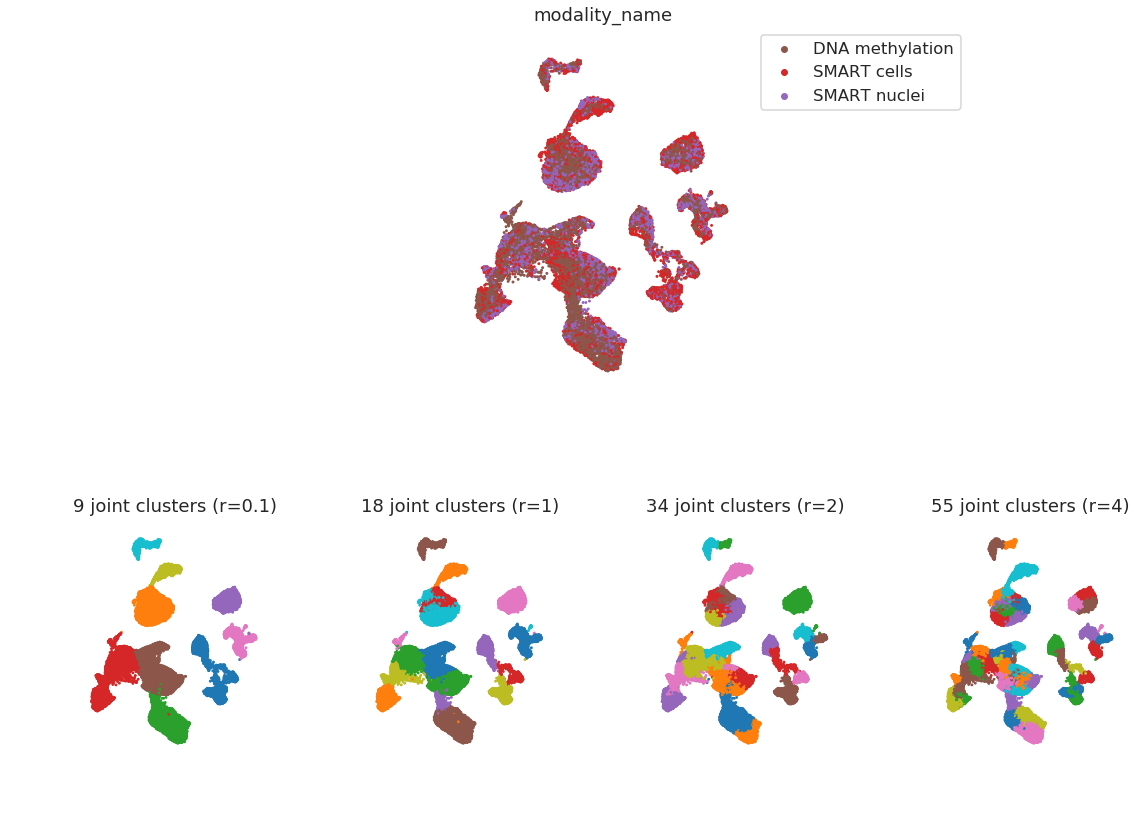

In [13]:
plot_1()

In [14]:
def plot_1_single(kw_colors='', show_labels=False, output=''):
    """plot umap cluster 
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', joint_cluster
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                         #  legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      legend_mode=-1,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    if show_labels:
        for clst, centroid in centroids['joint'].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst)+'_'+joint_annot.loc[clst, 'annot'],
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()
        
def plot_2_single(output=''):
    """Plot umap - modality
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

def plot_3(output='', 
           show_labels=False):
    """Plot umap - cluster - each modality
    """
    n = len(mods_selected)
    nx = 3
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(6*nx,6*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'

    for ax, mod in zip(axs, mods_selected):
        snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
    
        if show_labels:
            for clst, centroid in centroids[mod].iterrows():
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        clst,
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=10,
                       )
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')


    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()


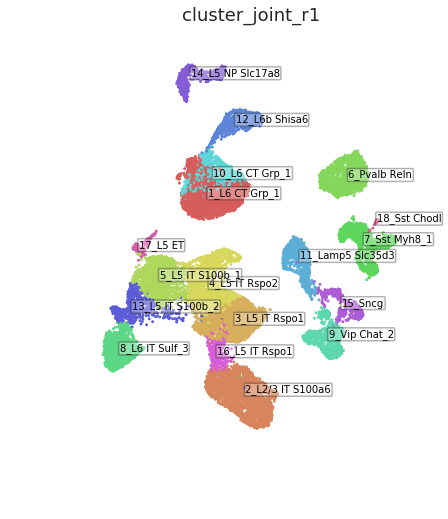

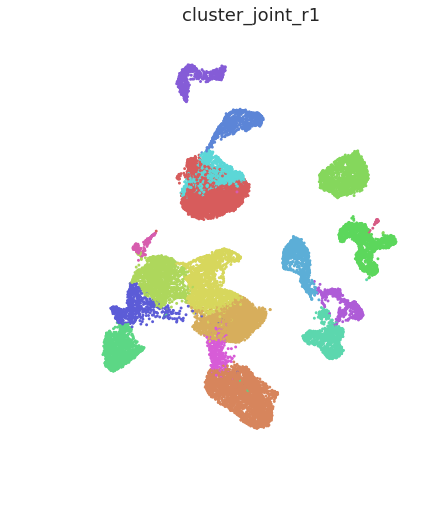

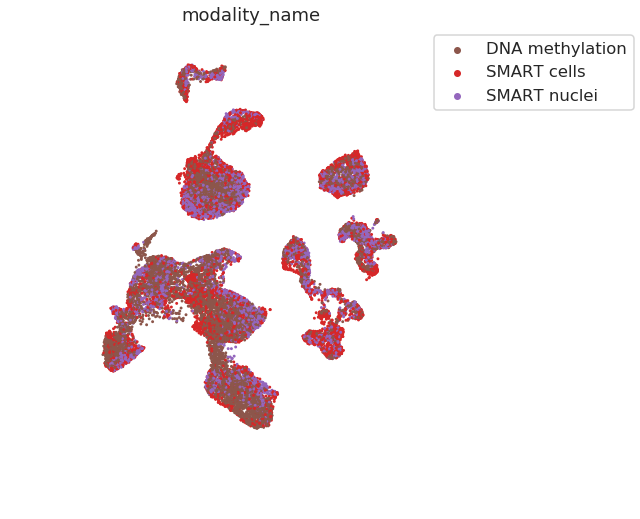

In [15]:
sample_n = 20000
# umap cluster
plot_1_single(joint_clst_colors, show_labels=True, output=output_figures.format('1-label', 'pdf'))
plot_1_single(joint_clst_colors, show_labels=False, output=output_figures.format('1-nolabel', 'pdf'))
plot_2_single(output=output_figures.format('2-nolabel', 'pdf'))

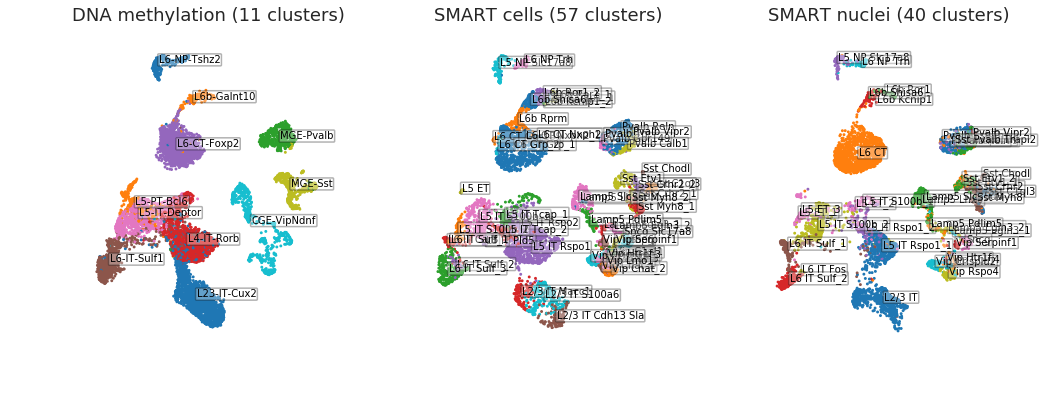

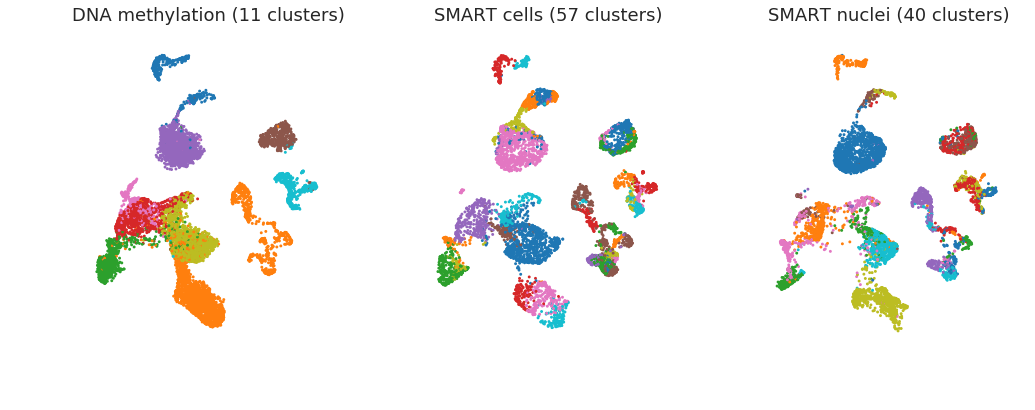

In [16]:
# umap modality
plot_3(show_labels=True, output=output_figures.format('3-label', 'pdf'))
plot_3(show_labels=False, output=output_figures.format('3-nolabel', 'pdf'))

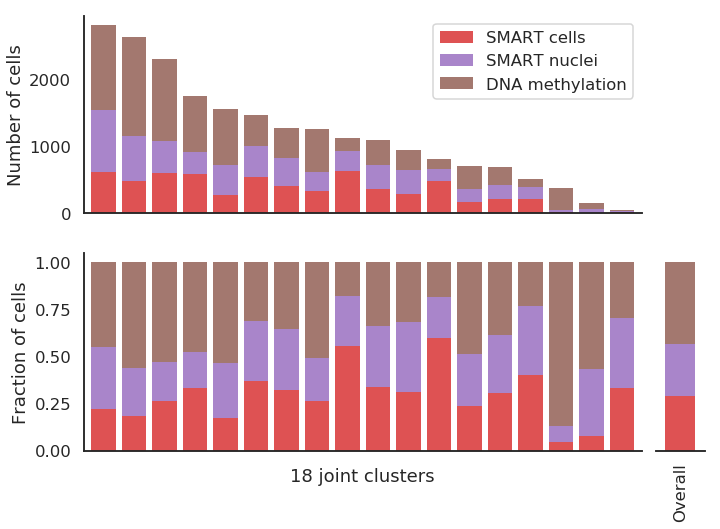

In [17]:

# histograms
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    fig, axs = plt.subplots(2, 1, figsize=(10,4*2))
    ax = axs[0]
    hist[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.legend(bbox_to_anchor=(1, 1))
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    

    ax = axs[1]
    hist_frac[mods_ordered[::-1]].rename(index=mod_names, columns=mod_names).plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                  color=[val for key, val in mod_colors.items()][::-1], # this controls mod_colors
                 )
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered[::-1]].to_frame().T.rename({0: 'Overall'}, axis=0)
                      .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                      color=[val for key, val in mod_colors.items()][::-1]) # this controls mod_colors
    )
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
#     fig.tight_layout()
    fig.savefig(output_figures.format(4, 'pdf'), bbox_inches='tight')
    plt.show()

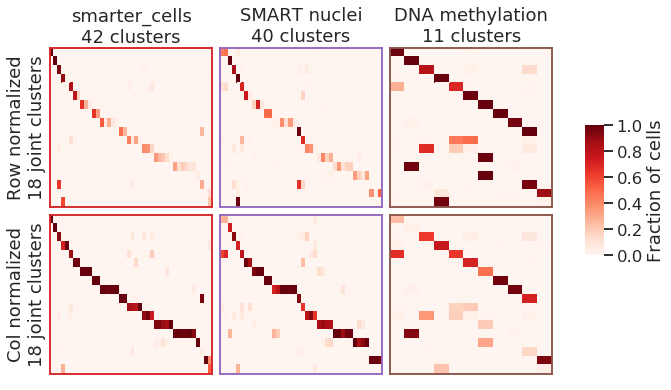

In [18]:
# confusion matrix

nx = len(mods_ordered)
ny = 2
heatmap_kws = {
    'xticklabels': False, 
    'yticklabels': False,
    'vmin': 0, 
    'vmax': 1,
    'cmap': 'Reds',
}

cbar_kws = {
    'orientation': 'vertical', 
    'label': 'Fraction of cells',
}

with sns.plotting_context('talk'):
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
    axs = axs.T
    cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
    njoint_clusters = len(df_info[joint_cluster].unique())
    for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
        conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, 'cluster'], 
                               df_info.loc[df_info['modality']==mod, joint_cluster],
                              )
        # normalize each joint cluster
        conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
        # normalize each orig cluster
        conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

        # plot normalized by joint 
        if i == 0:
            # order both row and col
            _X = conf_mat_njoint
            _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.3)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=True,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
            g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

            order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        else:
            # order just row (orig)
            _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=False,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel('')

            order_orig = _rX.index.values # Will be fixed for the mod clusters  
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)

        # plot normalized by orig (according to the axis of normalized by joint) 
        _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
        g = sns.heatmap(_X.T, 
                    cbar=False,
                    ax=ax[1],
                    **heatmap_kws,
                   )
        if i == 0:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
        else:
            g.axes.set_xlabel('')
            g.axes.set_ylabel('')
        # bounding box
        for _, spine in g.axes.spines.items():
            spine.set_visible(True)
            spine.set_color(settings[mod].color)
#             spine.set_linewidth(3)
            
    plt.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format(5, 'pdf'), bbox_inches='tight')
    plt.show()

#### Heatmap of correlation of cluster centroids 
- imputed data

In [19]:
mods_included = mods_selected
mod_reference = features_selected[0]
cells_all = np.load(output_cells_all, allow_pickle=True)
imputed_data = np.load(output_imputed_data_format.format(mod_reference), allow_pickle=True)

# cluster centroids of imputed data
cluster_centroids = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([joint_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids.keys():
            cluster_centroids[mod] = {}
        cluster_centroids[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
# print(cluster_centroids)

# Saving the objects:
with open(output_cluster_centroids, 'wb') as f: 
    pickle.dump((
                cluster_centroids
                ), f)

In [20]:
cluster_centroids_df = collections.OrderedDict()
for mod in mods_selected:
    if mod in mods_included:
        cluster_centroids_df[mod] = pd.DataFrame(cluster_centroids[mod])

# each modality and cluster
uniq_clusters = df_info[joint_cluster].unique()
corr_grand_clusters = np.hstack([[mod+'_'+str(clst)
                                for clst in cluster_centroids_df[mod].columns.values]
                                for mod in mods_included])

# grand correlation matrix
corr_grand = {}
for i, mod_x in enumerate(mods_included):
    for j, mod_y in enumerate(mods_included):
        if j >= i:
            gene_x = cluster_centroids_df[mod_x].index.values
            gene_y = cluster_centroids_df[mod_y].index.values
            gene_common = np.intersect1d(gene_x, gene_y)
            _x = (cluster_centroids_df[mod_x].loc[gene_common]).rank(axis=0).T.values
            _y = (cluster_centroids_df[mod_y].loc[gene_common]).rank(axis=0).T.values
            corr = np.corrcoef(_x, _y)[:len(_x), len(_x):]
            corr_grand[(i, j)] = corr
            if j != i:
                corr_grand[(j, i)] = corr.T
                
corr_grand = np.hstack([np.vstack([
                    corr_grand[(i, j)] for i in range(len(mods_included))
                    ])
                for j in range(len(mods_included))
                ])

# labels
corr_grand_label = np.hstack([[str(clst) + "_" + str(joint_annot.loc[clst, 'annot'])
                               for clst in cluster_centroids_df[mod].columns.values] 
                            for mod in mods_included
                            ])
corr_grand_clsts = np.hstack([cluster_centroids_df[mod].columns.values
                            for mod in mods_included
                            ])
corr_grand_mods = np.hstack([
                            [mod]*len(cluster_centroids_df[mod].columns.values) for mod in mods_included
                            ])

# colors
corr_grand_mod_colors = np.array([settings[mod].color for mod in corr_grand_mods])
corr_grand_clst_colors = np.array([joint_clst_colors[clst] for clst in corr_grand_clsts])

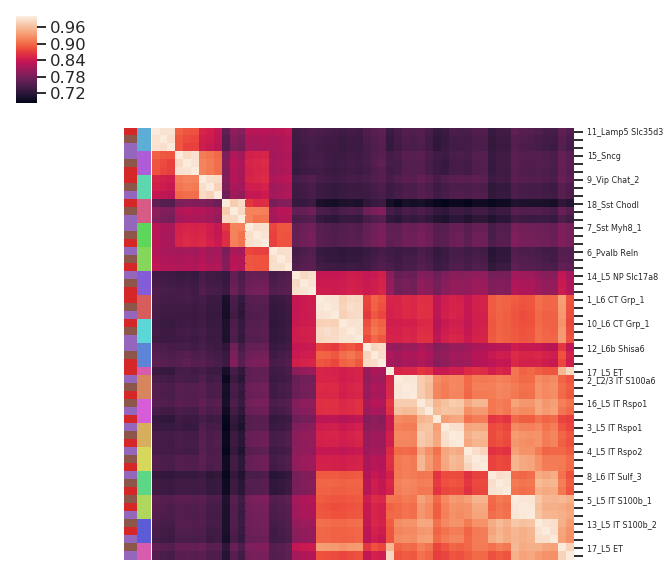

In [21]:
mat = corr_grand
Z = sch.linkage(mat, method='average')
dn = sch.dendrogram(Z, no_plot=True)

g = sns.clustermap(mat[dn['leaves'],:][:,dn['leaves']], 
                   row_cluster=False, col_cluster=False,
                   row_colors=[corr_grand_mod_colors[dn['leaves']], 
                               corr_grand_clst_colors[dn['leaves']], 
                              ], 
                   yticklabels=snmcseq_utils.dedup_array_elements(corr_grand_label[dn['leaves']]),
                   xticklabels=[],
#                    figsize=(8, 12),
                  )
g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
g.savefig(output_figures.format('8_cluster_heatmap', 'pdf'), bbox_inches='tight')
plt.show()

# Gene level features:

In [22]:
df_genes = pd.read_csv(PATH_GENEBODY_ANNOTATION, sep='\t')
df_genes['gene_id_abbr'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gene_id_abbr')
print(df_genes.shape)
df_genes.head()

(53379, 7)


,gene_id,gene_name,chr,start,end,strand,gene_type
gene_id_abbr,,,,,,,
ENSMUSG00000102693,ENSMUSG00000102693.1,4933401J01Rik,chr1,3073253,3074322,+,TEC
ENSMUSG00000064842,ENSMUSG00000064842.1,Gm26206,chr1,3102016,3102125,+,snRNA
ENSMUSG00000051951,ENSMUSG00000051951.5,Xkr4,chr1,3205901,3671498,-,protein_coding
ENSMUSG00000102851,ENSMUSG00000102851.1,Gm18956,chr1,3252757,3253236,+,processed_pseudogene
ENSMUSG00000103377,ENSMUSG00000103377.1,Gm37180,chr1,3365731,3368549,-,TEC


In [23]:
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
df_genes_v2.head()

,gene_id_abbr,gene_id,chr,start,end,strand,gene_type
gene_name,,,,,,,
0610005C13Rik,ENSMUSG00000109644,ENSMUSG00000109644.1,chr7,45567794,45575327,-,antisense_RNA
0610006L08Rik,ENSMUSG00000108652,ENSMUSG00000108652.1,chr7,74818818,74853813,-,lincRNA
0610009B22Rik,ENSMUSG00000007777,ENSMUSG00000007777.9,chr11,51685386,51688874,-,protein_coding
0610009E02Rik,ENSMUSG00000086714,ENSMUSG00000086714.1,chr2,26445696,26459390,+,processed_transcript
0610009L18Rik,ENSMUSG00000043644,ENSMUSG00000043644.4,chr11,120348678,120351190,+,bidirectional_promoter_lncRNA


In [24]:
f_meta_format = '{0}/{1}_metadata.tsv'
f_data_format = '{0}/{1}_{2}raw.{3}'
f_hvftr_format = '{0}/{1}_hvfeatures.{2}'
f_ftr_format = '{0}/{1}_features.{2}'

In [25]:
gxc_ftrs = {}
for mod in mods_selected:
    ti = time.time()
    print(mod)
    
    # read data matrix
    if settings[mod].mod_category == 'mc':
        f_data = f_ftr_format.format(DATA_DIR, mod, 'tsv')
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = pd.read_csv(f_data, sep='\t', index_col=0)
        print(time.time()-ti)
        
    else:
        f_data = f_ftr_format.format(DATA_DIR, mod, 'npz') 
        f_data_gene = f_ftr_format.format(DATA_DIR, mod, 'gene') 
        f_data_cell = f_ftr_format.format(DATA_DIR, mod, 'cell') 
        
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = snmcseq_utils.load_gc_matrix(f_data_gene, f_data_cell, f_data) # checked dimensions in agreement internally
        print(gxc_ftrs[mod].data.shape)
        print(time.time()-ti)
    
    print(mod, "Total time used: {}".format(time.time()-ti))
    

snmcseq_gene
snmcseq_gene Reading in files 3.886222839355469e-05
103.04393005371094
snmcseq_gene Total time used: 103.04401326179504
smarter_cells
smarter_cells Reading in files 0.0002815723419189453
(32324, 6244)
8.144968271255493
smarter_cells Total time used: 8.14498519897461
smarter_nuclei
smarter_nuclei Reading in files 3.0994415283203125e-05
(32324, 5911)
4.83733606338501
smarter_nuclei Total time used: 4.837352514266968


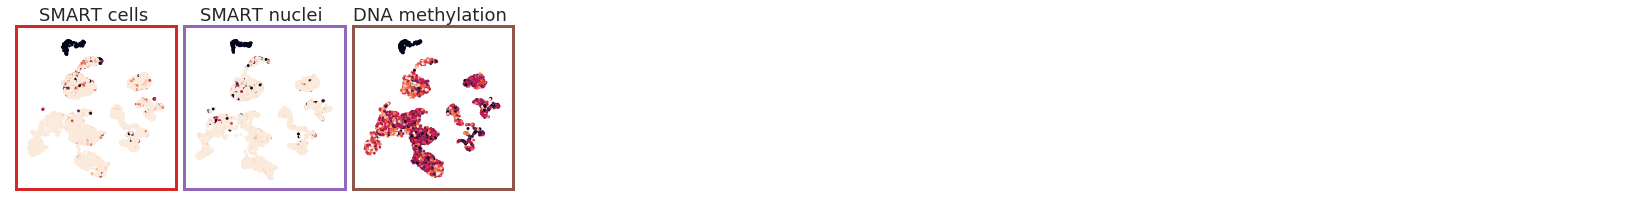

In [26]:
genes_inq = [
    'Tshz2',
#     'Bcl6', 
#     'Slco2a1', 
#     'Hpgd', 
#     'Npsr1', 
#     'Tshz2',
]
    
sample_n = 5000

with sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 9
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if settings[mod].mod_category == 'mc':
            genes = gxc_ftrs[mod].index.values
            gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
            gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
            gene_data = gxc_ftrs[mod].iloc[gene_idx].T.rename(columns={gene_ids_inq[0]: genes_inq[0]})
            # normalize gene_data
        else:
            genes = gxc_ftrs[mod].gene
            cells = gxc_ftrs[mod].cell
            gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
            gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
            gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
            gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
            
#             # normalize gene_data
#             gene_data = gene_data.applymap(lambda x: np.log10(x+1))
        
        # normalize gene_data
        gene_data = settings[mod].mod_direction*(gene_data - gene_data.mean())/gene_data.std()

        df_mod = df_info[df_info['modality']==mod]
        if sample_n > len(df_mod):
            df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
        else:
            df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                         .sample(sample_n, replace=False)
                      )
    
        if i == 0: 
            cbar = False
        else:
            cbar = False
        snmcseq_utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
                                          s=2,
                                          cbar=cbar,
                                          cbar_ax=cbar_ax,
                                          cmap='rocket_r',
                                          rasterized=True,
                                         )
        ax.set_title('{} '.format(settings[mod].name, ))
#         ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

In [27]:
genes_inq = [
    'Snap25',
    
    'Satb2',
    'Camk2a',
    'Tbr1',
    
    'Gad1',
    'Gad2',
    'Slc6a1',
    
    'Cux1',
    'Cux2',
    'Rorb',
    'Deptor',
    'Vat1l',
    'Sulf1',
    'Tle4',
    'Foxp2',
    'Grik3',
    'Bcl6',
    'Tshz2', 
    
    'Lhx6',
    'Adarb2',
    
    'Pvalb',
    'Sox6',
    'Gria1',
    
    'Prox1',
    'Sv2c',
    ]

clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

df_plots = {} 
for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
    if settings[mod].mod_category == 'mc':
        genes = gxc_ftrs[mod].index.values
        gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
        gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
        gene_data = (gxc_ftrs[mod].iloc[gene_idx].T
                                  .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
                    )
        # normalize gene_data
    else:
        genes = gxc_ftrs[mod].gene
        cells = gxc_ftrs[mod].cell
        gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
        gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
        gene_idx = gene_idx[gene_idx!=-1] # remove -1
        
        gene_data = gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense().T
        gene_data = (pd.DataFrame(gene_data, index=cells, columns=gene_ids_inq)
                       .rename(columns={a: b for a, b in zip(gene_ids_inq, genes_inq)})
                    )
#         # normalize gene_data
    
    
    df_mod = df_info.loc[df_info['modality']==mod, [joint_cluster]]
    if sample_n > len(df_mod):
        df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
    else:
        df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                     .sample(sample_n, replace=False)
                  )
    df_plot = df_plot.groupby(joint_cluster).mean()
    
    # normalize gene_data
#     df_plot = settings[mod].mod_direction*(df_plot - df_plot.mean(axis=0))/df_plot.std(axis=0)
    df_plot = settings[mod].mod_direction*df_plot
    df_plots[mod] = df_plot.T.reindex(
                                    index=genes_inq, 
                                    columns=clsts_uniq,
                                    )

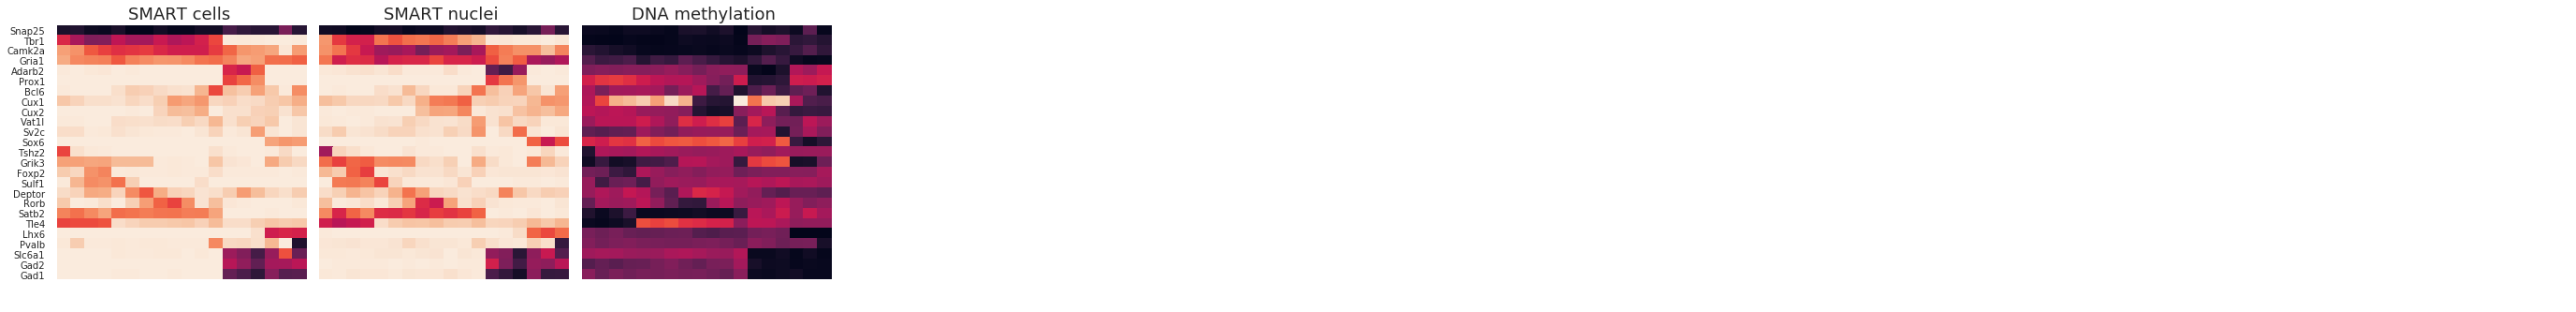

In [28]:
import scipy.cluster.hierarchy as sch
with sns.plotting_context('talk'), sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 9
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(5*nx,5*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if i == 0: 
            cbar = False
            # row gene
            Z = sch.linkage(df_plots[mod], method='average', metric='euclidean', optimal_ordering=True)
            dn = sch.dendrogram(Z, no_plot=True)['leaves']
            # col clst
            Z = sch.linkage(df_plots[mod].T, method='average', metric='euclidean', optimal_ordering=True)
            dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
        else:
            cbar = False
            
        sns.heatmap(df_plots[mod].iloc[dn, dn_clst], ax=ax, 
                                     cbar=cbar,
                                    yticklabels=True,
                                     cbar_ax=cbar_ax,
                                     cmap='rocket_r',
                                     )
        ax.set_title('{} '.format(settings[mod].name, ))
        ax.set_xticks([])
        
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)
        else:
            ax.set_yticks([])
        ax.set_xlabel('')
            
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('7_gene_heatmap', 'pdf'), bbox_inches='tight')
    plt.show()
    